In [8]:
# initialization
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## See steps in MNIST notebook

In [38]:
# network configuration
N = [100, 50, 50, 30]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
p_inference = get_p_arr(0.1)

# prob. of failure at train
p_trains = np.linspace(0, 0.5, 5)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 10

# number of runs for each p
runs = 20

def get_dataset():
    (x_train, y_train), (x_test, y_test) = boston_housing.load_data()
    return x_train, y_train, x_test, y_test

In [42]:
def get_results(p):
    # obtaining the distribution after 10 epochs
    results = []
    
    # current prob. of failure array
    p_train = get_p_arr(p)
    
    def unravel(name, data):
        return {name + '_train': data['train'], name + '_test': data['test']}
    
    for _ in tqdm(range(runs)):
        exp = TrainExperiment(*get_dataset(), N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)
        
        results += [{**unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                    }]
        K.clear_session()
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

In [8]:
exp = TrainExperiment(*get_dataset(), N = N, p_inference = p_inference, p_train = get_p_arr(0.01), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)

In [19]:
# array of repetitions values
rs = np.arange(30)[1:]

In [ ]:
# obtaining accuracy for each repetition parameter
results = [exp.get_mae_crash(repetitions = r) for r in tqdm(rs)]

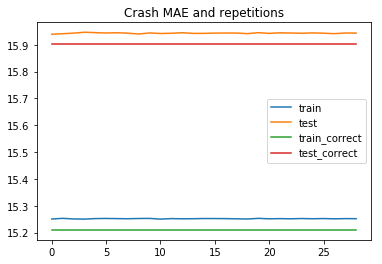

In [30]:
plt.figure()
plt.title('Crash MAE and repetitions')
plt.plot([x['train'] for x in results], label = 'train')
plt.plot([x['test'] for x in results], label = 'test')
plt.plot(range(len(results)), [exp.get_mae_correct()['train']] * len(results), label = 'train_correct')
plt.plot(range(len(results)), [exp.get_mae_correct()['test']] * len(results), label = 'test_correct')
plt.legend()
plt.show()

In [11]:
# 10 repetitions is enough

In [43]:
# obtaining results
results_array = [get_results(p) for p in p_trains]

100%|██████████| 20/20 [02:29<00:00,  6.66s/it]


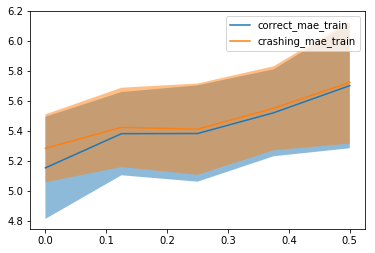

In [44]:
plt.figure()

def plot_quantity(results_array, name):
    means = np.array([np.mean(r[name]) for r in results_array])
    stds  = [np.std(r[name]) for r in results_array]
    plt.plot(p_trains, means, label = name)
    plt.fill_between(p_trains, means - stds, means + stds, alpha = 0.5)

plot_quantity(results_array, 'correct_mae_train')
plot_quantity(results_array, 'crashing_mae_train')
plt.legend()

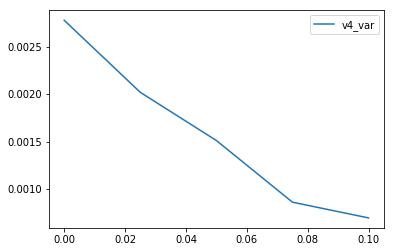

In [23]:
plt.figure()
plt.plot(p_trains, [np.mean(r['v4_var']) for r in results_array], label = 'v4_var')
#plt.plot(p_trains, [np.mean(np.abs(r['v4_mean'])) for r in results_array], label = 'v4_mean')
plt.legend()

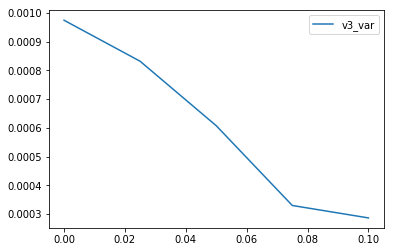

In [24]:
plt.figure()
plt.plot(p_trains, [np.mean(r['v3_var']) for r in results_array], label = 'v3_var')
#plt.plot(p_trains, [np.mean(np.abs(r['v3_mean'])) for r in results_array], label = 'v3_mean')
plt.legend()

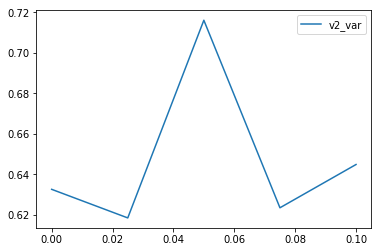

In [25]:
plt.figure()
plt.plot(p_trains, [np.mean(r['v2_var']) for r in results_array], label = 'v2_var')
#plt.plot(p_trains, [np.mean(np.abs(r['v2_mean'])) for r in results_array], label = 'v2_mean')
plt.legend()